In [3]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.coordinates import SkyCoord
import chime_frb_constants as constants
import datetime
import sys
import os

from astropy.time import Time
from astropy.time import TimeDelta
from astropy.timeseries import TimeSeries
from datetime import datetime
from datetime import timedelta

%matplotlib inline

In [4]:
import pandas as pd

In [5]:
from scipy import stats

In [6]:
import matplotlib.dates as mdates
import matplotlib.units as munits

In [7]:
sys.path.insert(0, '/arc/home/mseth/beam-model')
import beam_model
from beam_model import composite as cmp
from beam_model import utils
from beam_model import config
from beam_model import bm_data
from beam_model.bm_data.get_data import main
from beam_model import formed
from beam_model.formed import FFTFormedBeamModel
from beam_model.formed import FFTFormedActualBeamModel
from beam_model.primary import DataDrivenSVD_v3PrimaryBeamModel
from beam_model.primary import DataDrivenPrimaryBeamModel
from beam_model.primary import PrimaryBeamModel

In [8]:
sys.path.insert(0, '/arc/home/mseth/frb-calibration-master')
import frb_calibration.calibration_scheduler_helpers as cal_scheduler

## Summary of Notebook ##

This is the kinda successful notebook testing the BF to Jy equation. 

It's not great but it's good enough?

**Setup info**
- Uses `get_sensitivity` function in `CompositeBeamModel`
- Calculates precise transit time from `calculate_next_transit_times_precise` 
- Uses timestamps **centered around transit time**, NOT starting from header time. (1s spacing) (These are used to calculate the positions input into `get_sensitivity`)

**Contents outline**
1. Load in observation & do some plots (dynamic spectra, timeseries, etc.) 

2. Load in beam model and set parameters (beam id, observing frequencies, header time)  
    a) Calculate the next transit time occuring after the header time   
    b) Make timestamps centered around the transit time  
    c) Make a list of x-y positions of Tau for every timestamp.   
        ii) Double-check the positions make sense with some plots   
    d) Calculate relative sensitivity (parameters: x-y positions, beam ID, frequencies) 
    
3. Correct for beam response 
    a) Plot time series for both data & beam response @ 600 MHz. Find the time when max intensity occurs for both.   
    b) At that time, get the spectra for both data & beam response. To correct: data/beam response.   
    c) To check, plot beam response vs. Tau A spectrum.  

## Load in and check data ##

In [9]:
# Load in the file
data = np.load('/arc/projects/chime_frb/mseth/tau_A/frb_TAU_A_2025-05-31_beam_1059.npz', allow_pickle=True) 
print(data)

In [10]:
# See what's in there
data.__dict__

{'_files': ['median_timeseries.npy',
  'spectra.npy',
  'fpga0s.npy',
  'fpgaNs.npy',
  'header_info.npy'],
 'files': ['median_timeseries', 'spectra', 'fpga0s', 'fpgaNs', 'header_info'],
 'allow_pickle': True,
 'max_header_size': 10000,
 'pickle_kwargs': {'encoding': 'ASCII', 'fix_imports': True},
 'zip': <zipfile.ZipFile file=<_io.BufferedReader name='/arc/projects/chime_frb/mseth/tau_A/frb_TAU_A_2025-05-31_beam_1059.npz'> mode='r'>,
 'f': <numpy.lib.npyio.BagObj at 0x7f8fa40c72e0>,
 'fid': <_io.BufferedReader name='/arc/projects/chime_frb/mseth/tau_A/frb_TAU_A_2025-05-31_beam_1059.npz'>}

In [11]:
header_test = data['header_info']
print(header_test)

[array(1748723179) datetime.datetime(2025, 5, 31, 20, 26, 19) 1059]


In [19]:
peak_ind = np.argmax(median_ts)
print(peak_ind)

1786


In [10]:
# Load in each of the arrays
spectra_test = data['spectra']
fpga0s_test = data['fpga0s']
fpgaNs_test = data['fpgaNs']
median_ts_test = data['median_timeseries']

print(spectra_test.shape)
print(median_ts_test.shape)

(16384, 3600)
(3600,)


In [155]:
# Format the data to plot 
ts_data = spectra_test.sum(axis=0)        #Time series (frequency-summed)
tm_avgd_sd = spectra_test.mean(axis=1)    #Time-averaged intensity spectrum
dts_600MHz = spectra_test[8192,:]     #Time series (600 MHz)

In [154]:
dts_600MHz_max = np.max(ts_600MHz_data)
dts_600MHz_maxidx = np.argmax(ts_600MHz_data)
dts_600MHz_maxtime = timestamp_list[dts_600MHz_maxidx]

print(dts_600MHz_maxtime)

2025-05-31 20:56:01.704651


In [ ]:
sp_maxtime_stack[sp_maxtime_stack==0]=np.nan

In [175]:
dsp_1787s = spectra_test[:,dts_600MHz_maxidx]
dsp_1787s[dsp_1787s==0] = np.nan # Remove any values that are 0 

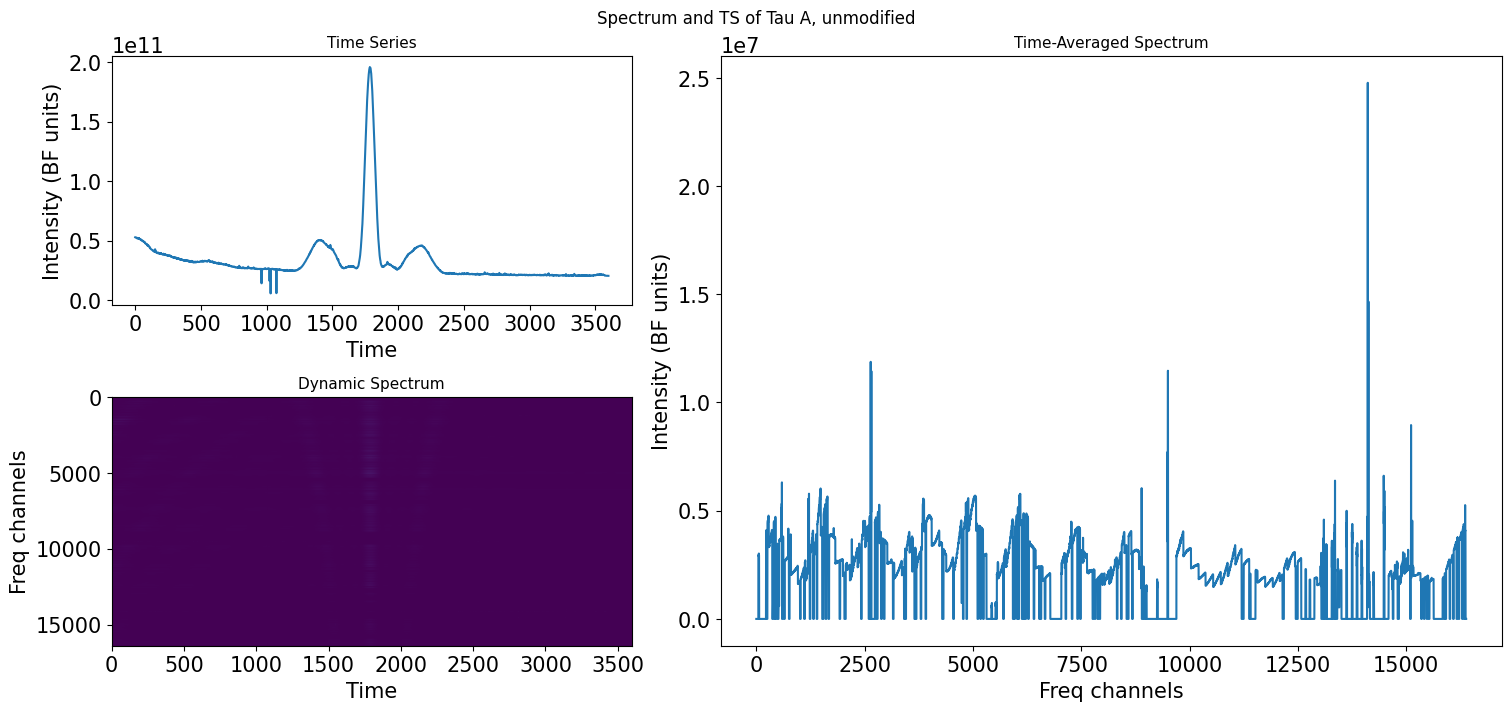

In [12]:
# Try plotting the data 
fig, axd = plt.subplot_mosaic(
    '''
    DDCCC
    AACCC
    ''',
    constrained_layout=True,
    figsize=(15,7)
)

axd['A'].imshow(spectra_test, aspect="auto")
axd['A'].set_title("Dynamic Spectrum", fontsize=11)
axd['A'].set_xlabel("Time")
axd['A'].set_ylabel("Freq channels")

#axd['B'].plot(spectra_test)
#axd['B'].set_title("Spectrum", fontsize=11)
#axd['B'].set_xlabel("Freq channels")
#axd['B'].set_ylabel("Intensity (BF units)")

axd['C'].plot(tm_avgd_sd)
axd['C'].set_title("Time-Averaged Spectrum", fontsize=11)
axd['C'].set_xlabel("Freq channels")
axd['C'].set_ylabel("Intensity (BF units)")

axd['D'].plot(ts_data)
axd['D'].set_title("Time Series", fontsize=11)
axd['D'].set_xlabel("Time")
axd['D'].set_ylabel("Intensity (BF units)")

#axd['E'].plot(ts_600MHz_data)
#axd['E'].set_title("Time Series at 600 MHz", fontsize=11)
#axd['E'].set_xlabel("Time")
#axd['E'].set_ylabel("Intensity (BF units)")

plt.suptitle("Spectrum and TS of Tau A, unmodified")
plt.show()

## Load in beam model & parameters ##

### Initial setup ###

In [13]:
main()

Fetching: primary_power_beam.npz
Fetching: beam_XX_v1.h5
Fetching: beam_YY_v1.h5
Fetching: beam_v1_SVD_diff_XX.h5
Fetching: beam_v1_SVD_diff_YY.h5
Fetching: beam_v1_SVD_YY.h5
Fetching: beam_v1_SVD_XX.h5
Download Complete


In [112]:
# Load in primary beam model
pbm = DataDrivenPrimaryBeamModel(config.current_config)

In [45]:
# Load in synthesized beam
sbm = FFTFormedActualBeamModel(config.current_config)

In [174]:
# Define some parameters
beam_id = 1059 

bandwidth = 400 
freq_res = bandwidth / 16384 
freqs = np.arange(400, 800, freq_res)
ref_freq = 600
freqs_Mhz = np.linspace(400, 800, len(sp_corrected)) # Making a list of frequencies for plotting later

time_header = header_test[1]
print(time_header)

2025-05-31 20:26:19


In [17]:
# Get source RA & Dec
source_name = "TAU_A"
coords = SkyCoord.from_name(source_name)
time = time_header

###

print("{}: ra={}, dec={}".format(source_name, coords.ra.deg, coords.dec.deg))
source_ra = coords.ra.deg
source_dec = coords.dec.deg

TAU_A: ra=83.6324, dec=22.0174


### Time (Using transit time) ###

In [18]:
# For the observation day, find which beams the object transits & at what time. 

print(
    "Upper transit: {}".format(
        cal_scheduler.calculate_next_upper_transit(source_ra, source_dec, time)
    )
)
print(
    "Lower transit: {}".format(
        cal_scheduler.calculate_next_lower_transit(source_ra, source_dec, time)
    )
)

transited_beam_ids = cal_scheduler.calculate_transit_beams_precise(
    source_ra, source_dec
)
transited_beam_ids_estimate = cal_scheduler.calculate_transit_beams_estimate(
    source_ra, source_dec
)
print("Precise beams transited: {}".format(sorted(transited_beam_ids)))
print("Estimated beams transited: {}".format(sorted(transited_beam_ids_estimate)))

transit_times = cal_scheduler.calculate_next_transit_times_precise(
    source_ra, source_dec, time, transited_beam_ids
)
print("Precise beams transited: {}".format(transited_beam_ids))
print("Precise transit times: {}".format(transit_times))

Upper transit: 2025-05-31 20:57:37.526893+00:00


[2025-07-25 13:58:42,540] INFO Warning: source at ra=83.6324,dec=22.0174 not in CHIME FOV during lower transit.


Lower transit: 2025-06-01 08:55:39.572158+00:00
Precise beams transited: [59, 1059, 2059, 3059]
Estimated beams transited: [59, 1059, 2059, 3059]
Precise beams transited: [59, 1059, 2059, 3059]
Precise transit times: [datetime.datetime(2025, 5, 31, 20, 54, 31, 764116), datetime.datetime(2025, 5, 31, 20, 56, 14, 704651), datetime.datetime(2025, 5, 31, 20, 57, 58, 653588), datetime.datetime(2025, 5, 31, 20, 59, 41, 48225)]


In [19]:
transit_time = transit_times[1]
print(f" Precise transit time for beam 1059: {transit_time}.")

 Precise transit time for beam 1059: 2025-05-31 20:56:14.704651.


In [20]:
# Make time series centering the transit time. 
freq = 'S'
samples_before = 3600/2
samples_after = 3600/2-1

start_datetime = transit_time - pd.Timedelta(seconds=samples_before)
end_datetime = transit_time + pd.Timedelta(seconds=samples_after)

timestamp_list = pd.date_range(start=start_datetime, end=end_datetime, freq=freq)
timestamp_idx = range(len(timestamp_list))

timestamps = pd.Series(timestamp_list, index=timestamp_idx)

/tmp/ipykernel_6431/1039446901.py:9: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  timestamp_list = pd.date_range(start=start_datetime, end=end_datetime, freq=freq)


In [21]:
transit_time_idx = np.where(timestamps == transit_time)[0]
print(transit_time_idx)

[1800]


In [22]:
print(timestamps)

0      2025-05-31 20:26:14.704651
1      2025-05-31 20:26:15.704651
2      2025-05-31 20:26:16.704651
3      2025-05-31 20:26:17.704651
4      2025-05-31 20:26:18.704651
                  ...            
3595   2025-05-31 21:26:09.704651
3596   2025-05-31 21:26:10.704651
3597   2025-05-31 21:26:11.704651
3598   2025-05-31 21:26:12.704651
3599   2025-05-31 21:26:13.704651
Length: 3600, dtype: datetime64[ns]


### Positions ###

In [29]:
# Generate a list of positions for each time in the time series. 

#Using time series that centers the calculated transit time 
pos_list = []

for i in timestamps:
    pos = utils.get_position_from_equatorial(source_ra, source_dec, i)
    pos_list.append(pos)
    
pos_array = np.array(pos_list)


In [24]:
# Plot positions of beams & Tau A 

# Beam 1059 
mybeam_pos_array = sbm.get_beam_positions(1059, ref_freq)
mybeam_pos = np.squeeze(mybeam_pos_array)

beam_x = mybeam_pos[0]
beam_y = mybeam_pos[1]

# All beams
all_beam_ids = np.arange(256, dtype=int) + np.arange(4, dtype=int)[:, None] * 1000
all_beam_ids = all_beam_ids.flat[:]
all_beam_pos = sbm.get_beam_positions(all_beam_ids, ref_freq)
all_beam_pos = np.squeeze(all_beam_pos)

all_beams_x = all_beam_pos[:,0]
all_beams_y = all_beam_pos[:,1]

# Tau A 
tauA_x = pos_array[:,0]
tauA_y = pos_array[:,1]

In [25]:
# Review the initial coordinates. 

start_x, start_y = utils.get_position_from_equatorial(source_ra, source_dec, transit_time)

print(f"The x-y coordinates of beam 1059 are: {mybeam_pos}.")
print(f"The x-y coordinates of Tau A at precise transit time are: {start_x:.2f}, {start_y:.2f}.")
print(f"The x-y coordinates of Tau A at header time are: {utils.get_position_from_equatorial(source_ra, source_dec, time_header)}.")

The x-y coordinates of beam 1059 are: [  0.         -27.45481395].
The x-y coordinates of Tau A at precise transit time are: -0.00, -27.29.
The x-y coordinates of Tau A at header time are: (-6.957839870927645, -26.893855979105904).


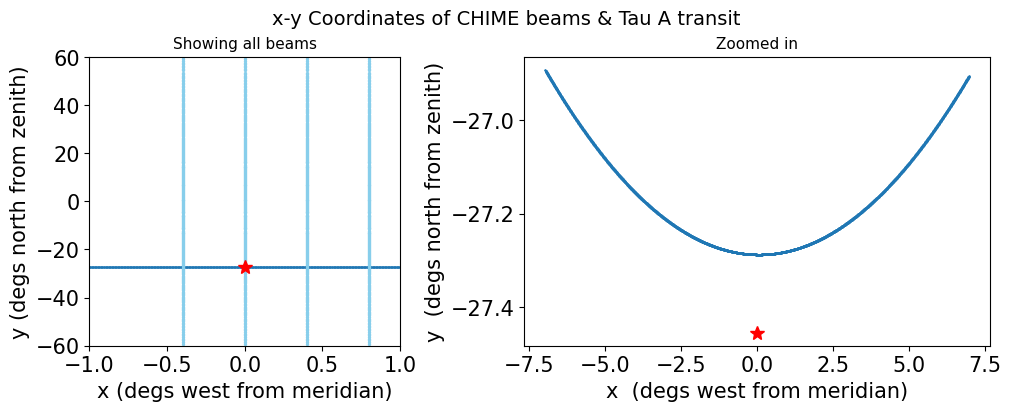

In [26]:
# Plot
fig, ax = plt.subplot_mosaic(
    '''
    AABBB
    ''',
    figsize = (10,4),
    constrained_layout=True)

#Including all the beams 
ax['A'].scatter(tauA_x, tauA_y, marker="o", s= 0.4, label="Tau A transit")
ax['A'].scatter(all_beams_x, all_beams_y, color="skyblue", label="Beam Coordinates", s=2)
ax['A'].plot(beam_x, beam_y, marker="*", color="r", markersize=10, label="Beam 1059")

ax['A'].set_xlim(-1, 1)
ax['A'].set_ylim(-60, 60)

ax['A'].set_xlabel("x (degs west from meridian)")
ax['A'].set_ylabel("y (degs north from zenith)")

ax['A'].set_title("Showing all beams", fontsize = 11)

#Zoomed in 
ax['B'].scatter(tauA_x, tauA_y, marker="o", s= 0.4)
ax['B'].plot(beam_x, beam_y, marker="*", color="r", markersize=10)

ax['B'].set_xlabel("x  (degs west from meridian)")
ax['B'].set_ylabel("y  (degs north from zenith)")
ax['B'].set_title("Zoomed in", fontsize = 11)

plt.suptitle("x-y Coordinates of CHIME beams & Tau A transit", fontsize = 14)
plt.show()

Text(0.5, 0.98, 'Path of Tau A transit')

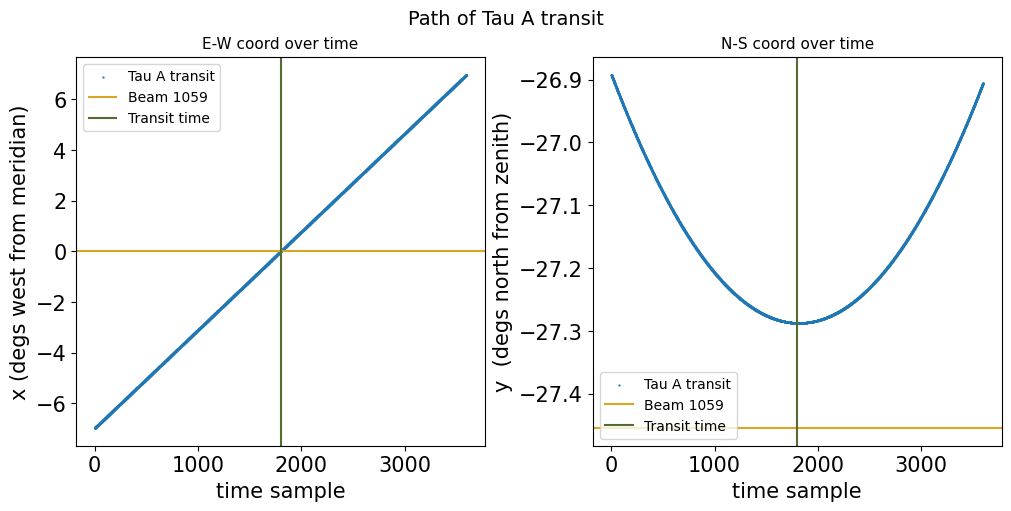

In [27]:
# Plot position over time for the transit 
fig, ax = plt.subplot_mosaic(
    '''
    AABB
    ''',
    figsize = (10,5),
    constrained_layout=True)

#Including all the beams 
ax['A'].scatter(timestamp_idx, tauA_x, marker="o", s= 0.4, label="Tau A transit")
ax['A'].axhline(y=beam_x, color='goldenrod', label='Beam 1059')
ax['A'].axvline(x=transit_time_idx, color='darkolivegreen', label='Transit time')

ax['A'].legend()
ax['A'].set_ylabel("x (degs west from meridian)")
ax['A'].set_xlabel("time sample")
ax['A'].set_title("E-W coord over time", fontsize = 11)

ax['B'].scatter(timestamp_idx, tauA_y, marker="o", s= 0.4, label="Tau A transit")
ax['B'].axhline(y=beam_y, color='goldenrod', label='Beam 1059')
ax['B'].axvline(x=transit_time_idx, color='darkolivegreen', label='Transit time')

ax['B'].legend()
ax['B'].set_ylabel("y  (degs north from zenith)")
ax['B'].set_xlabel("time sample")
ax['B'].set_title("N-S coord over time", fontsize = 11)

plt.suptitle("Path of Tau A transit", fontsize = 14)

In [28]:
print(beam_x)

0.0


## Calculating Sensitivities ##

### Load in the responses for primary & synthesized beams

In [158]:
## Primary response 

p_sensitivities = pbm.get_sensitivity(beam_id, pos_array, freqs)
p_response = np.squeeze(p_sensitivities)

#Time series at 600 Mhz
p_ts_600MHz = p_response[:,8192]

p_ts_600MHz_max = np.max(pts_600MHz)
pts_600MHz_maxidx = np.argmax(pts_600MHz)
pts_600MHz_maxtime = timestamps[pts_600MHz_maxidx]   # Timestamp for when beam response is at the maximum

#Spectrum at certain time 
psp_1800s = p_response[pts_600MHz_maxidx,:]      # Time that beam response 600MHz time series is max
psp_1787s = p_response[ts_maxidx,:]              # Time that data 600 MHz time series is max 

NotImplementedError: get_sensitivity should be implemented in sub-class

In [198]:
p_sensitivities.shape

(3600, 16384)

In [ ]:
## Synthesized response 

s_sensitivities = sbm.get_sensitivity(beam_id, pos_array, freqs)
s_response = np.squeeze(s_sensitivities)

#Time series at 600 Mhz
sts_600MHz = s_response[:,8192]

sts_600MHz_max = np.max(sts_600MHz)
sts_600MHz_maxidx = np.argmax(sts_600MHz)
sts_600MHz_maxtime = timestamps[sts_600MHz_maxidx]   # Timestamp for when beam response is at the maximum

#Spectrum at certain time 
ssp_1800s = s_response[sts_600MHz_maxidx,:]      # Time that beam response 600MHz time series is max
ssp_1787s = s_response[ts_maxidx,:]              # Time that data 600 MHz time series is max 

In [166]:
## Combined response 

c_response = p_response * s_response

#Time series at 600 Mhz
cts_600MHz = c_response[:,8192]

cts_600MHz_max = np.max(cts_600MHz)
cts_600MHz_maxidx = np.argmax(cts_600MHz)
cts_600MHz_maxtime = timestamps[cts_600MHz_maxidx]   # Timestamp for when beam response is at the maximum

#Spectrum at certain time 
csp_1800s = c_response[cts_600MHz_maxidx,:]      # Time that beam response 600MHz time series is max
csp_1787s = c_response[ts_maxidx,:]              # Time that data 600 MHz time series is max 

### Examine primary, synthesized, and combined responses

In [147]:
## Function to plot beam response for one model 

def plot_response(response, ts_600MHz, sp_time, response_name):

    fig, axd = plt.subplot_mosaic(
    '''
    CCCCC
    AABBB
    ''',
    constrained_layout=True,
    figsize=(7,5)
    )

    axd['A'].imshow(response, aspect="auto")
    axd['A'].set_title("Sensitivities across all times & freqs", fontsize=11)
    axd['A'].set_xlabel("Freq channels")
    axd['A'].set_ylabel("Time (1s sampling)")

    axd['B'].plot(ts_600MHz)
    
    axd['B'].scatter(np.argmax(ts_600MHz), np.max(ts_600MHz), color='violet' )
    axd['B'].annotate(f't={np.argmax(ts_600MHz)}', xy=(np.argmax(ts_600MHz), np.max(ts_600MHz) ))
    
    axd['B'].set_title("Sensitivities at 600 Mhz across all times", fontsize=11)
    axd['B'].set_xlabel("Time (1s sampling)")
    axd['B'].set_ylabel("Relative Sensitivity")

    axd['C'].plot(sp_time)
    axd['C'].set_title(f"Beam response at t={np.argmax(ts_600MHz)}", fontsize=11)
    axd['C'].set_xlabel("Freq channels")
    axd['C'].set_ylabel("Relative Sensitivity")

    #axd['D'].plot(median_ts_test)
    #axd['D'].set_title("Time Series", fontsize=11)
    #axd['D'].set_xlabel("Time")%matplotlib ipympl 
    #axd['D'].set_ylabel("Intensity (BF units)")

    plt.suptitle(f"{response_name} Beam Response of Beam 1059 for a Tau A transit")
    plt.show()

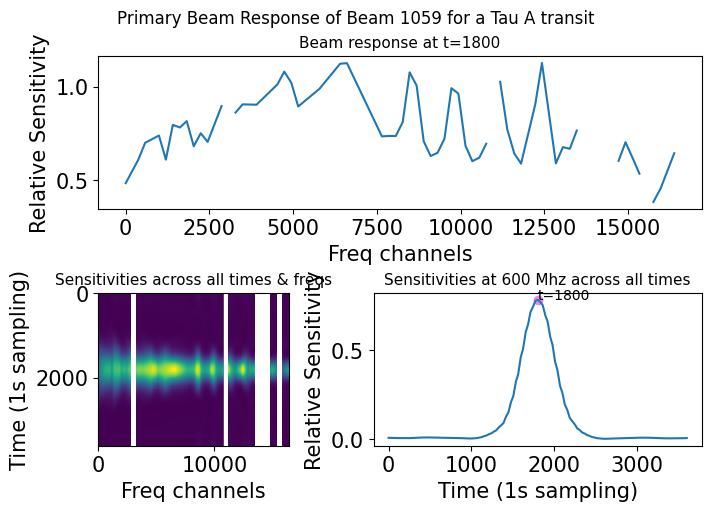

In [148]:
plot_response(p_response, pts_600MHz, psp_1800s, 'Primary')

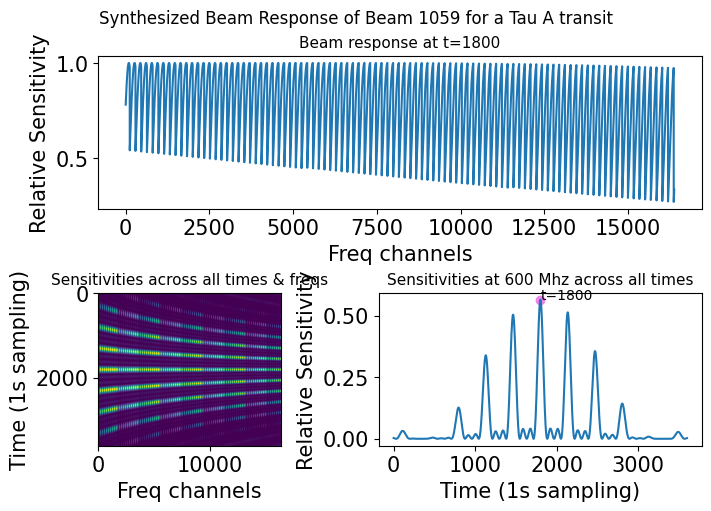

In [149]:
plot_response(s_response, sts_600MHz, ssp_1800s, 'Synthesized')

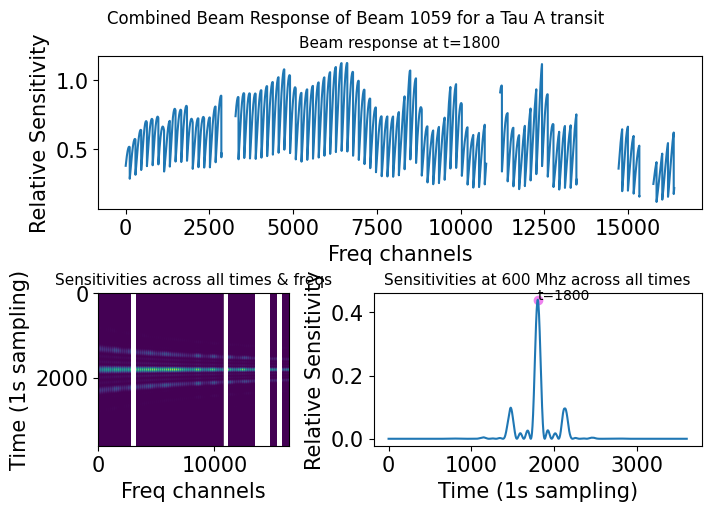

In [150]:
plot_response(c_response, cts_600MHz, csp_1800s, 'Combined')

Text(0, 0.5, 'Relative Sensitivity')

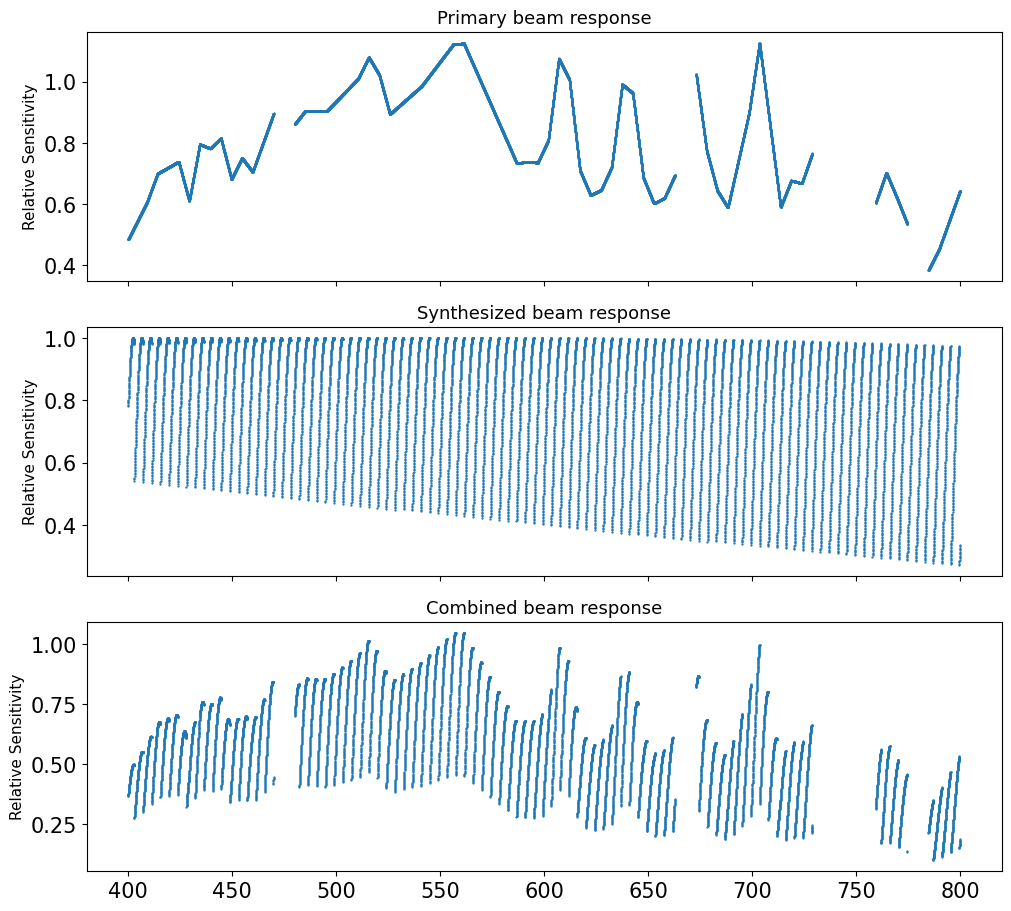

In [167]:
fig, axd = plt.subplot_mosaic(
    '''
    AAA
    BBB
    CCC
    ''',
    constrained_layout=True,
    #gridspec_kw={'height_ratios':[0.6, 0.6, 1, 1]},
    figsize=(10,9),
    sharex=True,
)
fig.set_constrained_layout_pads(hspace=0.06)

axd['A'].set_title("Primary beam response", fontsize=13)
axd['A'].scatter(freqs_Mhz, psp_1800s, s=0.4)
axd['A'].set_ylabel("Relative Sensitivity", fontsize=11)

axd['B'].set_title("Synthesized beam response", fontsize=13)
axd['B'].scatter(freqs_Mhz, ssp_1800s, s=0.4)
axd['B'].set_ylabel("Relative Sensitivity", fontsize=11)

axd['C'].set_title("Combined beam response", fontsize=13)
axd['C'].scatter(freqs_Mhz, csp_1787s, s=0.4)
axd['C'].set_ylabel("Relative Sensitivity", fontsize=11)


### Compare data and beam response

Text(0.5, 0.98, 'Time Series @ 600 MHz')

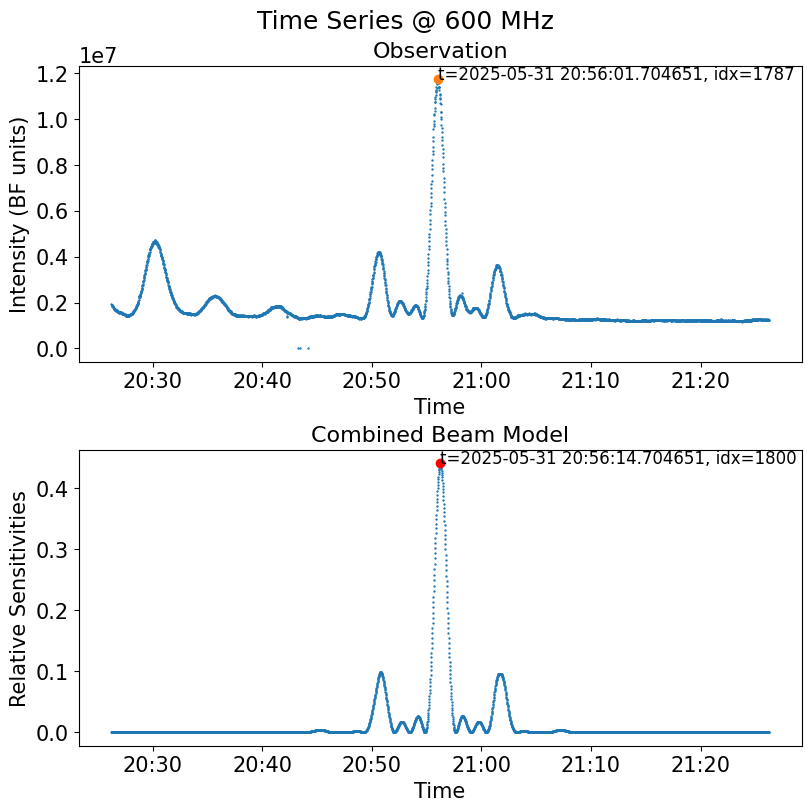

In [161]:
fig, axs = plt.subplot_mosaic(
    '''
    AAA
    BBB
    ''',
    layout='constrained', figsize=(8,8))

locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
formatter.formats = ['',
                     '',
                     '',
                     '',
                     '%H:%M',
                     '%M:%S.%f',]
formatter.zero_formats = [''] + formatter.formats[:-1]
formatter.zero_formats[4] = '%H:%M'

formatter.offset_formats = ['',
                            '',
                            '',
                            '',
                            '',
                            '%Y %b %d %H',]
# Actual data
axs['A'].xaxis.set_major_locator(locator)
axs['A'].xaxis.set_major_formatter(formatter)

axs['A'].scatter(timestamp_list, dts_600MHz, s=0.5)

axs['A'].scatter(dts_600MHz_maxtime, np.max(dts_600MHz))
axs['A'].annotate(f't={dts_600MHz_maxtime}, idx={np.argmax(dts_600MHz)}', 
            xy = (dts_600MHz_maxtime, np.max(dts_600MHz)),
            fontsize=12)

axs['A'].set_title("Observation", fontsize=16)
axs['A'].set_xlabel("Time")
axs['A'].set_ylabel("Intensity (BF units)")


# Beam model 
axs['B'].xaxis.set_major_locator(locator)
axs['B'].xaxis.set_major_formatter(formatter)

axs['B'].scatter(timestamp_list, cts_600MHz, s=0.5)
axs['B'].scatter(cts_600MHz_maxtime, np.max(cts_600MHz), color='r')


axs['B'].annotate(f't={cts_600MHz_maxtime}, idx={np.argmax(cts_600MHz)}', 
            xy = (cts_600MHz_maxtime, np.max(cts_600MHz)),
            fontsize=12)

axs['B'].set_title("Combined Beam Model", fontsize=16,)
axs['B'].set_xlabel("Time")
axs['B'].set_ylabel("Relative Sensitivities")

plt.suptitle("Time Series @ 600 MHz", fontsize=18)

### Correct for beam response 

In [177]:
# Divide data by relative sensitivity (spectrum at t=1787s)

sp_corrected = dsp_1787s / csp_1800s

In [ ]:
# Define conversion equation

def bf_to_jy(bf_int, f_good):
    factor = (np.square(1024) * 128) / (np.square(4) * 0.806745 * 400)
    result = bf_int / ( factor * np.square(f_good) ) 
    return result

In [179]:
# Apply conversion equation

sp_jansky = bf_to_jy(bf_int=sp_corrected,
                     f_good=0.9)

sp_jansky[sp_jansky==0]=np.nan

Text(0.5, 0.98, 'Spectra at peak')

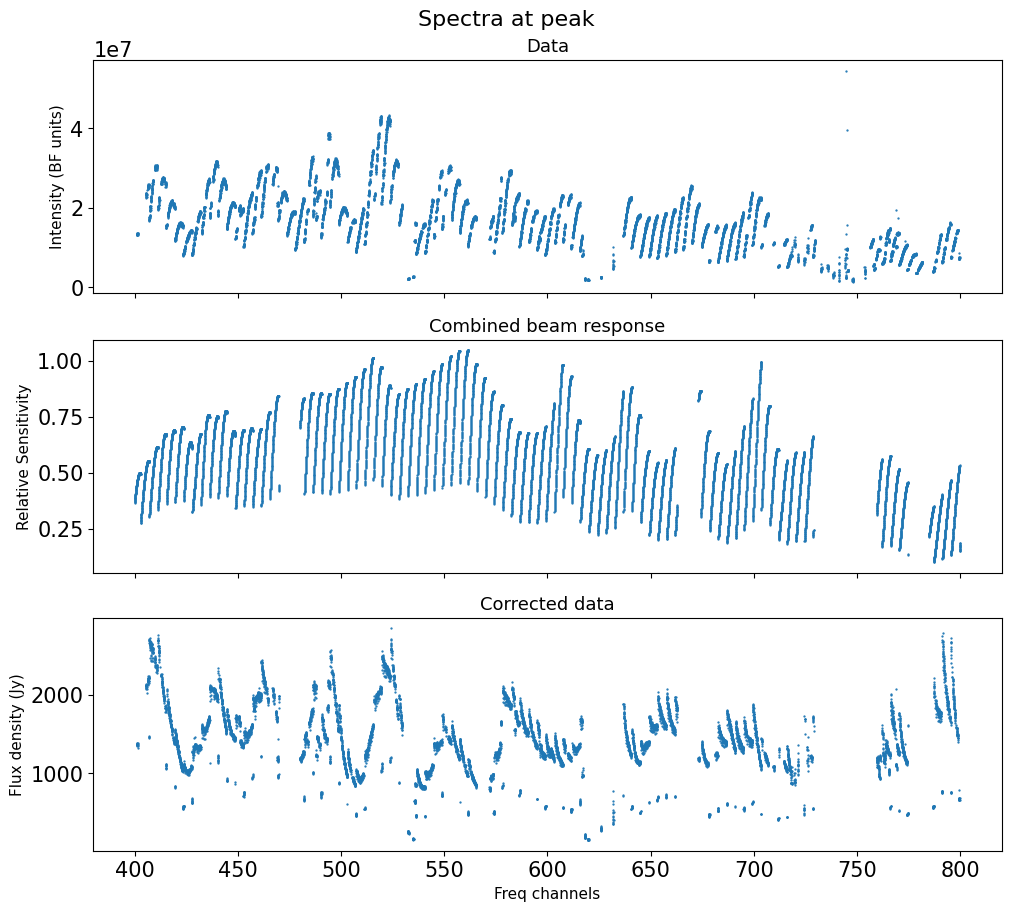

In [180]:
# Plot uncorrected data, beam response, and corrected data

fig, axd = plt.subplot_mosaic(
    '''
    AAA
    BBB
    CCC
    ''',
    constrained_layout=True,
    figsize=(10,9),
    sharex=True,
)
fig.set_constrained_layout_pads(hspace=0.06)

# Data (Uncorrected)
axd['A'].set_title("Data", fontsize=13)
axd['A'].scatter(freqs_Mhz, dsp_1787s, s=0.4)
axd['A'].set_ylabel("Intensity (BF units)", fontsize=11)

# Beam response
axd['B'].scatter(freqs_Mhz, csp_1787s, s=0.4)
axd['B'].set_title("Combined beam response", fontsize=13)
axd['B'].set_ylabel("Relative Sensitivity", fontsize=11)

# Data (corrected)
axd['C'].scatter(freqs_Mhz, sp_jansky, s=0.4)
axd['C'].set_title("Corrected data", fontsize=13)
axd['C'].set_xlabel("Freq channels", fontsize=11)
axd['C'].set_ylabel("Flux density (Jy)", fontsize=11)


plt.suptitle("Spectra at peak", fontsize=16)

### Let's plot spectra for Tau A against this to check how well we did

In [181]:
# Make a function for the spectrum (from Perley & Butler 2016)

def spectrum(a_0, a_1, a_2, a_3, GHz):
    exponent = a_0 + (a_1 * np.log10(GHz)) + (a_2 * np.square(np.log10(GHz))) + (a_3 * np.power(np.log10(GHz),3))
    result = np.power(10, exponent)
    return result 

In [182]:
# Generate the spectrum for Tau A (coefficients from Perley & Butler 2016)

tauA_spectrum = spectrum(a_0 = 2.9516,
                         a_1 = -0.217,
                         a_2 = -0.047, 
                         a_3 = -0.067,
                         GHz = freqs/1000)

In [184]:
# Make the spectrum into an array paired with the frequencies

tauA_spectrum_stack = np.column_stack((tauA_spectrum, freqs_Mhz))
tauA_spectrum_stack[tauA_spectrum_stack==0]=np.nan

print(tauA_spectrum_stack)

[[1083.25905844  400.        ]
 [1083.24508037  400.02441555]
 [1083.23110345  400.04883111]
 ...
 [ 938.11783     799.95116889]
 [ 938.11182386  799.97558445]
 [ 938.10581792  800.        ]]


Text(0.5, 0.98, 'Spectra at peak')

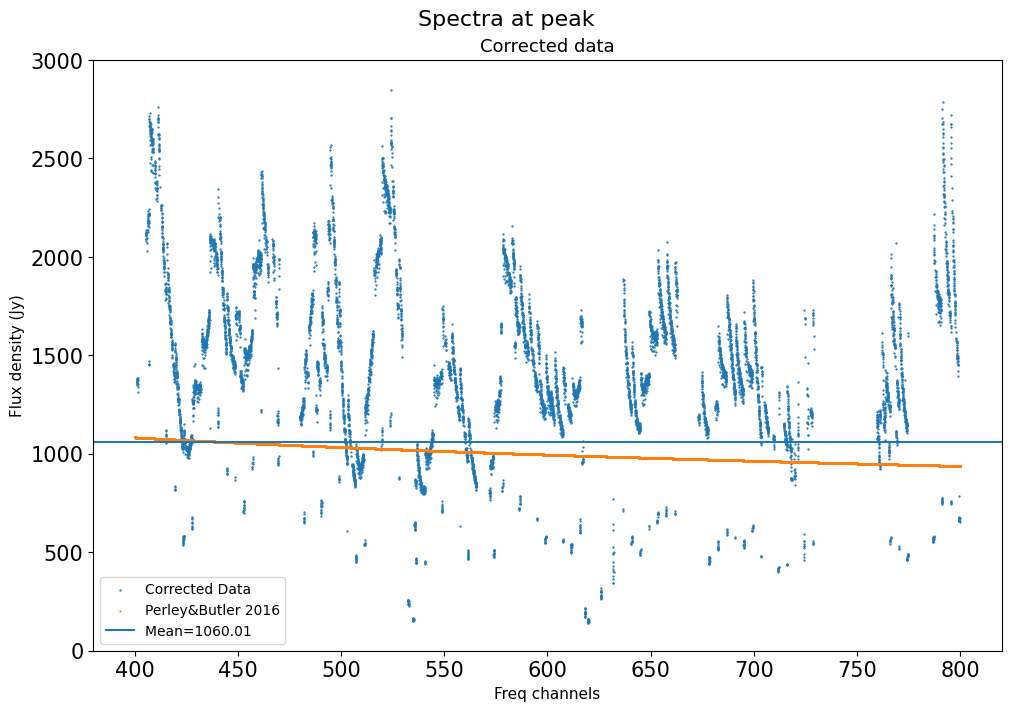

In [188]:
# Plot corrected data vs. modeled spectrum
fig, axd = plt.subplot_mosaic(
    '''
    CCC
    ''',
    constrained_layout=True,
    figsize=(10,7),
    sharex=True,
)
fig.set_constrained_layout_pads(hspace=0.06)

axd['C'].scatter(freqs_Mhz, sp_jansky, s=0.4, label="Corrected Data")
axd['C'].scatter(freqs_Mhz, tauA_spectrum, s=0.4, label="Perley&Butler 2016")

axd['C'].axhline(y=np.nanmean(sp_jansky_stack[:,0]), label=(f"Mean={np.nanmean(sp_jansky_stack[:,0]):.2f} ") )
axd['C'].set_ylim(0, 3000)

axd['C'].legend()


axd['C'].set_title("Corrected data", fontsize=13)
axd['C'].set_xlabel("Freq channels", fontsize=11)
axd['C'].set_ylabel("Flux density (Jy)", fontsize=11)


plt.suptitle("Spectra at peak", fontsize=16)

In [196]:
dsp_jansky = bf_to_jy(bf_int=dsp_1787s,
                     f_good=0.95)

dsp_jansky[dsp_jansky==0]=np.nan

Text(0.5, 0.98, 'Spectra at peak')

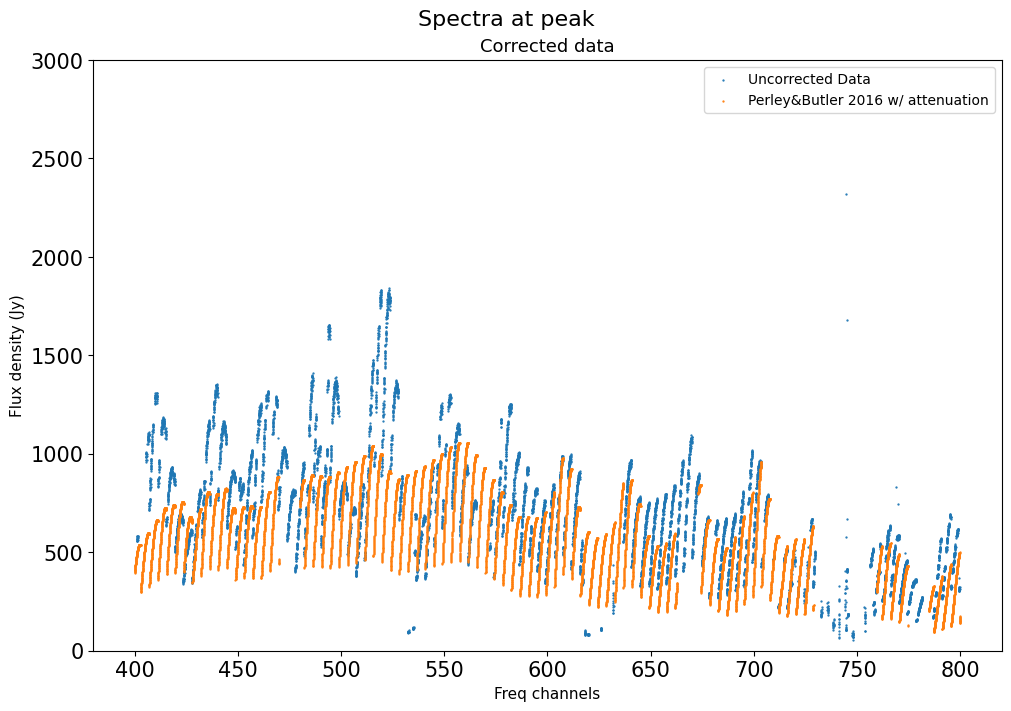

In [197]:
# Plot uncorrected data vs. modeled spectrum attenuated by beam response
fig, axd = plt.subplot_mosaic(
    '''
    CCC
    ''',
    constrained_layout=True,
    figsize=(10,7),
    sharex=True,
)
fig.set_constrained_layout_pads(hspace=0.06)

axd['C'].scatter(freqs_Mhz, dsp_jansky, s=0.4, label="Uncorrected Data")
axd['C'].scatter(freqs_Mhz, tauA_spectrum * csp_1787s, s=0.4, label="Perley&Butler 2016 w/ attenuation")

axd['C'].set_ylim(0, 3000)

axd['C'].legend()


axd['C'].set_title("Corrected data", fontsize=13)
axd['C'].set_xlabel("Freq channels", fontsize=11)
axd['C'].set_ylabel("Flux density (Jy)", fontsize=11)


plt.suptitle("Spectra at peak", fontsize=16)